In [100]:
import pandas as pd
import missingno as msno
from datetime import datetime
import numpy as np
import sklearn.compose._column_transformer
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
customers = pd.read_csv("../data/olist_customers_dataset.csv") # Client
geolocalisation = pd.read_csv("../data/olist_geolocation_dataset.csv") # Loc

order_items = pd.read_csv("../data/olist_order_items_dataset.csv") # Commandes items
order_payments = pd.read_csv("../data/olist_order_payments_dataset.csv") # Commandes paiement
order_reviews = pd.read_csv("../data/olist_order_reviews_dataset.csv") # Commandes reviews
orders = pd.read_csv("../data/olist_orders_dataset.csv") # Commandes

sellers = pd.read_csv("../data/olist_sellers_dataset.csv") # Vendeurs
products = pd.read_csv("../data/olist_products_dataset.csv") # Produits
cat_trans = pd.read_csv('../data/product_category_name_translation.csv') # Translate


In [3]:
order_cust = pd.merge(left=customers, right=orders, how="left", left_on="customer_id", right_on="customer_id")
forder_cust = pd.merge(left=order_cust, right=order_items, how="outer", left_on="order_id", right_on="order_id")

forder_cust['total'] = forder_cust[["price", "freight_value"]].sum(axis=1)

## Recence 

In [4]:
dates = ['order_purchase_timestamp', 'order_approved_at','order_delivered_carrier_date', 'order_delivered_customer_date','order_estimated_delivery_date','shipping_limit_date']
forder_cust[dates] =forder_cust[dates].apply(pd.to_datetime, format='%Y-%m-%d')
date_1 = forder_cust.sort_values(by ='order_approved_at',ascending = False)


recence = date_1.groupby('customer_unique_id').agg(last_date =('order_approved_at','max')).reset_index()


recence['periode']=(date_1.order_approved_at.max()-recence.last_date).dt.days
recence.dropna(inplace=True)
recence.periode = recence.periode.astype(int)

def recence_transform(row):
    if row['periode'] <= 140:
        return 1
    if row['periode']> 140 and row['periode'] <= 280:
        return 2
    if row['periode']>280 and row['periode'] <= 420:
        return 3
    if row['periode']> 420 and row['periode'] <= 560:
        return 4
    if row['periode']> 560:
        return 5 

recence['r_value']=recence.apply(lambda row: recence_transform(row),axis=1)
recence.head()

,customer_unique_id,last_date,periode,r_value
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,116,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,118,1
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,541,4
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17,325,3
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52,292,3


In [5]:

liste1 =cat_trans.product_category_name.tolist()
liste2 = cat_trans.product_category_name_english.tolist()
dict = {}
for key in liste1:
    for value in liste2:
        dict[key] = value
        liste2.remove(value)
        break
products.product_category_name=products.product_category_name.map(dict)
order_reviews.drop(['review_comment_title','review_comment_message'],inplace=True,axis=1)
order_reviews['review_score'].dropna(inplace=True)

## Merging pour l'analyse des commandes

### reajustement du df payments pour obtenir une ligne = une commande

In [6]:
def get_mode(x):
    return x.mode().iloc[0]

In [7]:
p1 = order_payments.groupby('order_id').agg(payment_installment = ('payment_installments',get_mode),payment_type = ('payment_type',get_mode),total_pay =('payment_value','sum')).reset_index()


### Merging products and order_items et les regrouper par commandes uniques

In [8]:
order_items.drop(['seller_id','price','freight_value'],inplace=True,axis=1)
products_item = pd.merge(order_items,products,how ='left',left_on='product_id',right_on='product_id')
a = products_item.groupby(['order_id','product_category_name']).agg(total_commande=('order_item_id','count'),prod =('product_id','nunique')).reset_index()
c = a.groupby('order_id').agg(category=('product_category_name',get_mode),items_commande = ('total_commande','sum'),prod_commande=('prod','sum')).reset_index()
df_commande = pd.merge(p1,c,how='left',left_on='order_id',right_on='order_id')
df_commande
#Dataframe montrant par commande , le type de paiement le plus utilisé, le total de la commande en R$, la catégorie du produit le plus commandé, le nb d'items commandé et le nombre de produits différents commandés


,order_id,payment_installment,payment_type,total_pay,category,items_commande,prod_commande
0,00010242fe8c5a6d1ba2dd792cb16214,2,credit_card,72.19,cool_stuff,1.0,1.0
1,00018f77f2f0320c557190d7a144bdd3,3,credit_card,259.83,pet_shop,1.0,1.0
2,000229ec398224ef6ca0657da4fc703e,5,credit_card,216.87,furniture_decor,1.0,1.0
3,00024acbcdf0a6daa1e931b038114c75,2,credit_card,25.78,perfumery,1.0,1.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,3,credit_card,218.04,garden_tools,1.0,1.0
...,...,...,...,...,...,...,...
99435,fffc94f6ce00a00581880bf54a75a037,1,boleto,343.40,housewares,1.0,1.0
99436,fffcd46ef2263f404302a634eb57f7eb,1,boleto,386.53,computers_accessories,1.0,1.0
99437,fffce4705a9662cd70adb13d4a31832d,3,credit_card,116.85,sports_leisure,1.0,1.0
99438,fffe18544ffabc95dfada21779c9644f,3,credit_card,64.71,computers_accessories,1.0,1.0


### Merging orders_items/products/payments

In [9]:
orders=orders.dropna()
orders[['order_purchase_timestamp','order_approved_at','order_delivered_customer_date']]= orders[['order_purchase_timestamp','order_approved_at','order_delivered_customer_date']].apply(pd.to_datetime)
orders['purchase_date']=orders.order_purchase_timestamp.dt.to_period('M')
orders['approval_time']= (orders['order_approved_at'] - orders['order_purchase_timestamp']).dt.days
orders['delivery_time'] = (orders['order_delivered_customer_date']-orders['order_purchase_timestamp']).dt.days
orders.delivery_time =orders.delivery_time.astype(int)
df_orders = orders[['order_id','customer_id','delivery_time','purchase_date']]

In [10]:
df_commande.category.nunique()

71

In [11]:
df_client = pd.merge(df_commande,df_orders,how='left',left_on='order_id',right_on='order_id')

In [12]:
df_client['months']=df_client.purchase_date.dt.month
season_dict = {1: 'Winter',
               2: 'Winter',
               3: 'Spring', 
               4: 'Spring',
               5: 'Spring',
               6: 'Summer',
               7: 'Summer',
               8: 'Summer',
               9: 'Autumn',
               10: 'Autumn',
               11: 'Autumn',
               12: 'Winter'}
df_client['Season'] = df_client['months'].map(season_dict)

In [13]:
df_client.category.nunique()

71

### REVIEW

In [14]:
df_review = order_reviews.groupby('order_id',).agg(rating = ('review_score','mean'),review = ('review_id','count')).reset_index()


### Merging df_client et df_review

In [15]:
df_merge = pd.merge(df_client,df_review,how='left',left_on='order_id',right_on='order_id')
df_merge

,order_id,payment_installment,payment_type,total_pay,category,items_commande,prod_commande,customer_id,delivery_time,purchase_date,months,Season,rating,review
0,00010242fe8c5a6d1ba2dd792cb16214,2,credit_card,72.19,cool_stuff,1.0,1.0,3ce436f183e68e07877b285a838db11a,7.0,2017-09,9,Autumn,5.0,1.0
1,00018f77f2f0320c557190d7a144bdd3,3,credit_card,259.83,pet_shop,1.0,1.0,f6dd3ec061db4e3987629fe6b26e5cce,16.0,2017-04,4,Spring,4.0,1.0
2,000229ec398224ef6ca0657da4fc703e,5,credit_card,216.87,furniture_decor,1.0,1.0,6489ae5e4333f3693df5ad4372dab6d3,7.0,2018-01,1,Winter,5.0,1.0
3,00024acbcdf0a6daa1e931b038114c75,2,credit_card,25.78,perfumery,1.0,1.0,d4eb9395c8c0431ee92fce09860c5a06,6.0,2018-08,8,Summer,4.0,1.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,3,credit_card,218.04,garden_tools,1.0,1.0,58dbd0b2d70206bf40e62cd34e84d795,25.0,2017-02,2,Winter,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99435,fffc94f6ce00a00581880bf54a75a037,1,boleto,343.40,housewares,1.0,1.0,b51593916b4b8e0d6f66f2ae24f2673d,17.0,2018-04,4,Spring,5.0,1.0
99436,fffcd46ef2263f404302a634eb57f7eb,1,boleto,386.53,computers_accessories,1.0,1.0,84c5d4fbaf120aae381fad077416eaa0,9.0,2018-07,7,Summer,5.0,1.0
99437,fffce4705a9662cd70adb13d4a31832d,3,credit_card,116.85,sports_leisure,1.0,1.0,29309aa813182aaddc9b259e31b870e6,4.0,2017-10,10,Autumn,5.0,1.0
99438,fffe18544ffabc95dfada21779c9644f,3,credit_card,64.71,computers_accessories,1.0,1.0,b5e6afd5a41800fdf401e0272ca74655,1.0,2017-08,8,Summer,5.0,1.0


In [16]:
df_merge2 = pd.merge(df_merge,customers,how='left',left_on='customer_id',right_on='customer_id')
df_merge2.drop(['customer_id','customer_zip_code_prefix'],axis=1,inplace=True)
df_merge2.dropna()
df_merge2.category.fillna('None',inplace=True)
sum_list = ['total_pay','items_commande','prod_commande','review']
mod_list = ['customer_city','customer_state','category','payment_type']#,'payment_type','category']
max_list = ['purchase_date']
last_list = ['Season','months']
mean_list = ['rating','delivery_time','payment_installment','freight_value','product_description_lenght','total_size']
count_list = ['order_id']
d1 = dict.fromkeys(sum_list, 'sum')
d2 = dict.fromkeys(mod_list, get_mode)
d3 = dict.fromkeys(max_list,'max')
d4 = dict.fromkeys(last_list,'last')
d5 = dict.fromkeys(mean_list,'mean')
d6 = dict.fromkeys(count_list,'count')
d = {**d1, **d2,**d3,**d4,**d5,**d6}

In [18]:
order_items = pd.read_csv("../data/olist_order_items_dataset.csv") # Commandes items
products = pd.read_csv("../data/olist_products_dataset.csv") # Produits

In [19]:
products['total_size']=products.product_height_cm*products.product_length_cm*products.product_width_cm

jpp = pd.merge(order_items,products,how='left',left_on='product_id',right_on='product_id')
jpp = jpp.groupby('order_id').agg({'freight_value':'mean','total_size':'mean','product_description_lenght':'mean'}).reset_index()
jpp

,order_id,freight_value,total_size,product_description_lenght
0,00010242fe8c5a6d1ba2dd792cb16214,13.29,3528.0,598.0
1,00018f77f2f0320c557190d7a144bdd3,19.93,60000.0,239.0
2,000229ec398224ef6ca0657da4fc703e,17.87,14157.0,695.0
3,00024acbcdf0a6daa1e931b038114c75,12.79,2400.0,480.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,18.14,42000.0,409.0
...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,43.41,53400.0,1002.0
98662,fffcd46ef2263f404302a634eb57f7eb,36.53,44460.0,232.0
98663,fffce4705a9662cd70adb13d4a31832d,16.95,9576.0,869.0
98664,fffe18544ffabc95dfada21779c9644f,8.72,8000.0,1306.0


In [20]:
df_merge3 = pd.merge(df_merge2,jpp,how='left',left_on='order_id',right_on='order_id')
df_merge3

,order_id,payment_installment,payment_type,total_pay,category,items_commande,prod_commande,delivery_time,purchase_date,months,Season,rating,review,customer_unique_id,customer_city,customer_state,freight_value,total_size,product_description_lenght
0,00010242fe8c5a6d1ba2dd792cb16214,2,credit_card,72.19,cool_stuff,1.0,1.0,7.0,2017-09,9,Autumn,5.0,1.0,871766c5855e863f6eccc05f988b23cb,campos dos goytacazes,RJ,13.29,3528.0,598.0
1,00018f77f2f0320c557190d7a144bdd3,3,credit_card,259.83,pet_shop,1.0,1.0,16.0,2017-04,4,Spring,4.0,1.0,eb28e67c4c0b83846050ddfb8a35d051,santa fe do sul,SP,19.93,60000.0,239.0
2,000229ec398224ef6ca0657da4fc703e,5,credit_card,216.87,furniture_decor,1.0,1.0,7.0,2018-01,1,Winter,5.0,1.0,3818d81c6709e39d06b2738a8d3a2474,para de minas,MG,17.87,14157.0,695.0
3,00024acbcdf0a6daa1e931b038114c75,2,credit_card,25.78,perfumery,1.0,1.0,6.0,2018-08,8,Summer,4.0,1.0,af861d436cfc08b2c2ddefd0ba074622,atibaia,SP,12.79,2400.0,480.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,3,credit_card,218.04,garden_tools,1.0,1.0,25.0,2017-02,2,Winter,5.0,1.0,64b576fb70d441e8f1b2d7d446e483c5,varzea paulista,SP,18.14,42000.0,409.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99435,fffc94f6ce00a00581880bf54a75a037,1,boleto,343.40,housewares,1.0,1.0,17.0,2018-04,4,Spring,5.0,1.0,0c9aeda10a71f369396d0c04dce13a64,sao luis,MA,43.41,53400.0,1002.0
99436,fffcd46ef2263f404302a634eb57f7eb,1,boleto,386.53,computers_accessories,1.0,1.0,9.0,2018-07,7,Summer,5.0,1.0,0da9fe112eae0c74d3ba1fe16de0988b,curitiba,PR,36.53,44460.0,232.0
99437,fffce4705a9662cd70adb13d4a31832d,3,credit_card,116.85,sports_leisure,1.0,1.0,4.0,2017-10,10,Autumn,5.0,1.0,cd79b407828f02fdbba457111c38e4c4,sao paulo,SP,16.95,9576.0,869.0
99438,fffe18544ffabc95dfada21779c9644f,3,credit_card,64.71,computers_accessories,1.0,1.0,1.0,2017-08,8,Summer,5.0,1.0,eb803377c9315b564bdedad672039306,vinhedo,SP,8.72,8000.0,1306.0


In [21]:
df_last = df_merge3.groupby('customer_unique_id').agg(d).reset_index()
rfm = pd.read_csv('data.csv')
rfm.drop(['zipcode','city','state','total','no_purchase_period'],axis=1,inplace=True)

In [31]:
df = pd.merge(df_last,rfm,how='left',left_on='customer_unique_id',right_on = 'id')
df.drop(['id','last_purchase','customer_unique_id'],axis=1,inplace=True)
df.dropna(how = 'any',inplace=True)

In [32]:
transformer = {'Meubles et décoration': ['bed_bath_table','furniture_decor','office_furniture','home_comfort_2','home_confort', 'housewares', 'furniture_living_room','kitchen_dining_laundry_garden_furniture', 'furniture_bedroom','furniture_mattress_and_upholstery'],
                'Électronique et informatique': ['audio','fixed_telephony','telephony', 'computers_accessories', 'electronics', 'consoles_games', 'computers', 'signaling_and_security','tablets_printing_image', 'cds_dvds_musicals', 'dvds_blu_ray', 'music'],
                'Santé et beauté': ['health_beauty', 'perfumery'],
                'Mode et accessoires': ['fashion_bags_accessories', 'fashion_underwear_beach', 'fashion_shoes', 'fashion_male_clothing', 'fashion_sport', 'luggage_accessories','fashio_female_clothing', 'fashion_childrens_clothes'],
                'Petits appareils ménagers': ['home_appliances','home_appliances_2','small_appliances', 'small_appliances_home_oven_and_coffee', 'air_conditioning'],
                'Outils et matériaux de construction': ['construction_tools_construction','construction_tools_safety','construction_tools_construction,' 'construction_tools_safety', 'construction_tools_lights', 'costruction_tools_garden', 'costruction_tools_tools','home_construction'],
                'Loisirs et sports':['sports_leisure', 'garden_tools', 'musical_instruments', 'cool_stuff', 'toys', 'books_general_interest', 'books_technical', 'books_imported', 'cine_photo', 'art', 'arts_and_craftmanship'],
                'Autres': ['stationery',  'watches_gifts', 'auto', 'christmas_supplies', 'drinks','baby', 'pet_shop', 'market_place', 'flowers', 'industry_commerce_and_business', 'food_drink', 'food', 'agro_industry_and_commerce', 'party_supplies', 'diapers_and_hygiene', 'security_and_services','la_cuisine'],
                'Inconnu' : ['None']
}        
keys =transformer.keys()
for key in keys:
  df.category = df.category.replace(to_replace=transformer[key], value=key)


In [33]:
df.columns =['total_pay', 'nb_total_items_commande', 'nb_prod_different', 'nb_review',
       'customer_city', 'customer_state', 'category', 'payment_type','purchase_date','Season',
       'months', 'rating_review', 'delivery_time', 'payment_installment',
       'freight_value', 'product_description_lenght', 'total_size', 'nb_total_commande',
       'freq', 'recense', 'montant']

In [34]:
df['panier_moyen']=df['total_pay']/df['nb_total_commande']
df.drop(['customer_city','customer_state'],axis=1,inplace=True)


### TESST

In [4]:
merged = pd.read_csv('merged.csv')
df = merged.copy()
df.recense = df.recense +3
df.freq = df.freq +3 


In [3]:
from sklearn.compose import make_column_selector,make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,FunctionTransformer,StandardScaler
from sklearn.manifold import TSNE
import plotly.express as px
from kmodes.kprototypes import KPrototypes

## Clustering 2017

In [120]:
df[df.Year=='2017'].shape[0]

40466

In [121]:
df[df.Year=='2018'].shape[0]

50765

In [52]:
df.sort_values('purchase_date',ascending=False,inplace=True)
df['Year']=df.purchase_date.astype(str).str[0:4]

In [53]:
df_2017 = df[df.Year=='2017'].drop(['purchase_date','months','Season','months','Year','nb_prod_different','nb_review','nb_total_items_commande','nb_total_commande','panier_moyen'],axis=1)
df_2017_index = df_2017.index.tolist()

In [54]:
df_2017

,total_pay,category,payment_type,rating_review,delivery_time,payment_installment,freight_value,product_description_lenght,total_size,freq,recense,montant
15663,143.01,Autres,boleto,5.0,19.0,1.0,26.100000,138.000000,4050.0,3,3.0,3
76716,56.00,Électronique et informatique,credit_card,1.0,21.0,1.0,15.100000,401.000000,4862.0,3,3.0,1
4321,73.66,Autres,credit_card,3.0,18.0,2.0,15.160000,309.000000,1071.0,3,3.0,1
28217,135.00,Loisirs et sports,credit_card,4.0,21.0,1.0,20.000000,1597.000000,23625.0,3,3.0,3
61851,298.17,Autres,credit_card,5.0,18.0,10.0,21.180000,1250.000000,880.0,3,3.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...
16712,164.21,Autres,credit_card,5.0,9.0,3.0,15.210000,748.000000,2704.0,3,3.0,3
6722,33.95,Électronique et informatique,boleto,4.0,5.0,1.0,10.960000,267.000000,627.0,3,3.0,1
51497,157.99,Loisirs et sports,credit_card,5.0,9.0,4.0,28.000000,1629.000000,39780.0,3,3.0,3
24214,146.01,Loisirs et sports,credit_card,2.0,10.0,10.0,16.020000,2751.000000,13020.0,3,3.0,3


In [55]:
def log(x):
    return np.log1p(abs(x))
transformer = FunctionTransformer(log)
transformer2 = make_column_transformer(
    (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=np.number)),
    (transformer,make_column_selector(dtype_include=np.number))
    )

In [56]:
new_columns = df_2017.select_dtypes(np.number).columns.tolist()+df_2017.select_dtypes(object).columns.to_list()
scaler = make_column_transformer((transformer,make_column_selector(dtype_include=np.number)),
remainder='passthrough'
)
normalize =make_column_transformer((StandardScaler(),make_column_selector(dtype_include=np.number)),
remainder='passthrough'
)
df_t = scaler.fit_transform(df_2017)
test = pd.DataFrame(df_t,columns=new_columns)


In [60]:
k = 5
df_test =normalize.fit_transform(test)
model = KPrototypes(n_clusters=k, init="Cao", verbose=2, n_jobs=-1, n_init=5, max_iter=50, random_state=42)

clusters = model.fit_predict(df_t, categorical=[10,11])


Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Run: 4, iteration: 1/50, moves: 9704, ncost: 102894.77288238646
Run: 2, iteration: 1/50, moves: 12538, ncost: 97358.88073627734
Run: 1, iteration: 1/50, moves: 14137, ncost: 94120.4327520031
Run: 3, iteration: 1/50, moves: 13984, ncost: 95635.74998664927
Run: 5, iteration: 1/50, moves: 10409, ncost: 92900.60472542749
Run: 2, iteration: 2/50, moves: 4683, ncost: 95917.39295732717
Run: 4, iteration: 2/50, moves: 6904, ncost: 99340.87640128097
Run: 1, iteration: 2/50, moves: 4900, ncost: 92631.34857991918
Run: 5, iteratio

In [61]:
clusters_list = []
for c in clusters:
    clusters_list.append(c)

In [62]:
df_2017['clusters']= clusters_list

## CLUSTERING 2017 N+3


In [63]:
df.purchase_date = pd.to_datetime(df.purchase_date)


In [64]:
df_2017_n3 = df[(df.purchase_date >= '2017') & (df.purchase_date <= '2018-03')].drop(['purchase_date','months','Season','months','Year','nb_prod_different','nb_review','nb_total_items_commande','nb_total_commande','panier_moyen'],axis=1)

In [65]:
new_columns = df_2017_n3.select_dtypes(np.number).columns.tolist()+df_2017_n3.select_dtypes(object).columns.to_list()
scaler = make_column_transformer((transformer,make_column_selector(dtype_include=np.number)),
remainder='passthrough'
)
normalize =make_column_transformer((StandardScaler(),make_column_selector(dtype_include=np.number)),
remainder='passthrough'
)
df_t2 = scaler.fit_transform(df_2017_n3)
test = pd.DataFrame(df_t2,columns=new_columns)

In [66]:
df_test =normalize.fit_transform(test)
model = KPrototypes(n_clusters=k, init="Cao", verbose=2, n_jobs=-1, n_init=5, max_iter=50, random_state=42)

clusters_n3 = model.fit_predict(df_t2, categorical=[10,11])
clusters_list_n3 = []
for c in clusters_n3:
    clusters_list_n3.append(c)


Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Run: 2, iteration: 1/50, moves: 18056, ncost: 155684.1332867462
Run: 4, iteration: 1/50, moves: 14430, ncost: 164354.97423707249
Run: 3, iteration: 1/50, moves: 21066, ncost: 154217.5608924118
Run: 5, iteration: 1/50, moves: 16105, ncost: 150086.94123890364
Run: 1, iteration: 1/50, moves: 20828, ncost: 152190.8751133077
Run: 2, iteration: 2/50, moves: 6656, ncost: 153729.02670066943
Run: 4, iteration: 2/50, moves: 8729, ncost: 160406.39680205256
Run: 3, iteration: 2/50, moves: 6558, ncost: 152531.62546152167
Run: 5, it

In [67]:
df_2017_n3['clusters']= clusters_list_n3

## Clustering 2017 n+6

In [68]:
df_2017_n6 = df[(df.purchase_date >= '2017') & (df.purchase_date <= '2018-06')].drop(['purchase_date','months','Season','months','Year','nb_prod_different','nb_review','nb_total_items_commande','nb_total_commande','panier_moyen'],axis=1)

In [69]:
df_t3 = scaler.fit_transform(df_2017_n6)
model = KPrototypes(n_clusters=k, init="Cao", verbose=2, n_jobs=-1, n_init=5, max_iter=50, random_state=42)

clusters_n6 = model.fit_predict(df_t3, categorical=[10,11])
clusters_list_n6 = []
for c in clusters_n6:
    clusters_list_n6.append(c)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Run: 5, iteration: 1/50, moves: 21471, ncost: 210060.64164620152
Run: 1, iteration: 1/50, moves: 27212, ncost: 212119.66014206246
Run: 4, iteration: 1/50, moves: 19866, ncost: 227314.96838401048
Run: 2, iteration: 1/50, moves: 24435, ncost: 217122.46466132277
Run: 3, iteration: 1/50, moves: 27748, ncost: 215222.58209536615
Run: 5, iteration: 2/50, moves: 5767, ncost: 209106.20767484303
Run: 4, iteration: 2/50, moves: 12480, ncost: 220143.63192919537
Run: 1, iteration: 2/50, moves: 9968, ncost: 209342.20335038102
Run: 3

In [70]:
df_2017_n6['clusters']=clusters_list_n6

## Clustering n+9

In [71]:
df_2017_n9 = df[(df.purchase_date >= '2017') & (df.purchase_date <= '2018-09')].drop(['purchase_date','months','Season','months','Year','nb_prod_different','nb_review','nb_total_items_commande','nb_total_commande','panier_moyen'],axis=1)

In [72]:
df_t4 = scaler.fit_transform(df_2017_n9)
model = KPrototypes(n_clusters=k, init="Cao", verbose=2, n_jobs=-1, n_init=5, max_iter=50, random_state=42)

clusters_n9 = model.fit_predict(df_t4, categorical=[10,11])
clusters_list_n9 = []
for c in clusters_n9:
    clusters_list_n9.append(c)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Run: 4, iteration: 1/50, moves: 24305, ncost: 268842.52293806773
Run: 3, iteration: 1/50, moves: 32041, ncost: 255373.48722170107
Run: 2, iteration: 1/50, moves: 27850, ncost: 257949.1164949695
Run: 5, iteration: 1/50, moves: 25027, ncost: 249725.09119482987
Run: 1, iteration: 1/50, moves: 32243, ncost: 251893.09287848554
Run: 4, iteration: 2/50, moves: 13433, ncost: 261968.89406142363
Run: 3, iteration: 2/50, moves: 10252, ncost: 252469.7240973587
Run: 2, iteration: 2/50, moves: 11372, ncost: 254303.37210656176
Run: 1

In [73]:
df_2017_n9['clusters']=clusters_list_n9

## Clustering 2018

In [74]:
df_2018 = df[(df.purchase_date >= '2017') & (df.purchase_date < '2019')].drop(['purchase_date','months','Season','months','Year','nb_prod_different','nb_review','nb_total_items_commande','nb_total_commande','panier_moyen'],axis=1)

In [75]:
df_t5 = scaler.fit_transform(df_2018)
model = KPrototypes(n_clusters=k, init="Cao", verbose=2, n_jobs=-1, n_init=5, max_iter=50, random_state=42)

clusters_2018 = model.fit_predict(df_t5, categorical=[10,11])
clusters_list_2018 = []
for c in clusters_2018:
    clusters_list_2018.append(c)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Run: 1, iteration: 1/50, moves: 32243, ncost: 251893.09287848554
Run: 2, iteration: 1/50, moves: 27850, ncost: 257949.1164949695
Run: 5, iteration: 1/50, moves: 25027, ncost: 249725.09119482987
Run: 3, iteration: 1/50, moves: 32041, ncost: 255373.48722170107
Run: 4, iteration: 1/50, moves: 24305, ncost: 268842.52293806773
Run: 1, iteration: 2/50, moves: 11287, ncost: 248632.42640064235
Run: 2, iteration: 2/50, moves: 11372, ncost: 254303.37210656176
Run: 5, iteration: 2/50, moves: 7028, ncost: 248387.15724220753
Run: 3

In [76]:
df_2018['clusters']=clusters_list_2018

## ARI SCORE

In [77]:
from sklearn.metrics.cluster import rand_score

In [78]:
t0 = df_2017.clusters.tolist()
t1 =df_2017_n3.clusters.loc[df_2017_index].tolist()
t2=df_2017_n6.clusters.loc[df_2017_index].tolist()
t3 = df_2017_n9.clusters.loc[df_2017_index].tolist()
t4=df_2018.clusters.loc[df_2017_index].tolist()

In [92]:
df_ari = pd.DataFrame(
    {   't0':t0,
        't1':t1,
        't2':t2,
        't3':t3,
        't4':t4
    }
)
ari_list = []

In [96]:
for elt in df_ari.columns:
    if elt == 't0':
        
    else:
        ari = rand_score(df_ari.t0,df_ari[elt])
        ari_list.append(ari)

In [ ]:
ari_keys = ['3','6','9','12']
ari_dict = dict(zip(ari_keys, ari_list))

In [106]:
ari_dict

{'3': 0.9311854422238185,
 '6': 0.8999398463479361,
 '9': 0.9338001434407404,
 '12': 0.9338001434407404}

<AxesSubplot:>

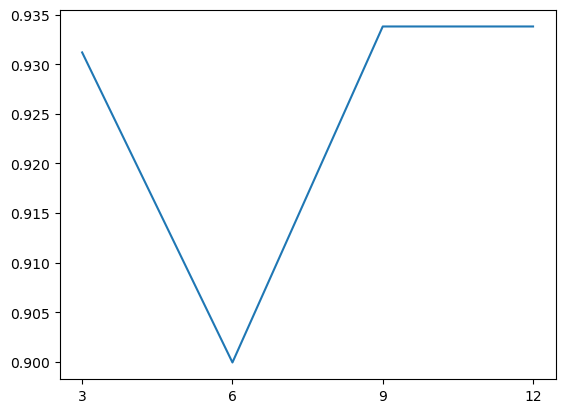

In [105]:
sns.lineplot(ari_dict)

## PCA

In [83]:
df_full = df.drop(['purchase_date','months','Season','months','Year','nb_prod_different','nb_review','nb_total_items_commande','nb_total_commande','panier_moyen'],axis=1)

In [107]:
df_ft = scaler.fit_transform(df_full)
k = 5
model = KPrototypes(n_clusters=k, init="Cao", verbose=2, n_jobs=-1, n_init=5, max_iter=50, random_state=42)

clusters_2018 = model.fit_predict(df_ft, categorical=[10,11])
clusters_list_2018 = []
for c in clusters_2018:
    clusters_list_2018.append(c)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Run: 5, iteration: 1/50, moves: 25131, ncost: 250499.13888264584
Run: 2, iteration: 1/50, moves: 27931, ncost: 258770.44361265464
Run: 3, iteration: 1/50, moves: 32159, ncost: 256155.14103249795
Run: 4, iteration: 1/50, moves: 24379, ncost: 269679.6453311599
Run: 1, iteration: 1/50, moves: 32341, ncost: 252672.03957248968
Run: 5, iteration: 2/50, moves: 7064, ncost: 249152.9096895061
Run: 2, iteration: 2/50, moves: 11405, ncost: 255121.3924158439
Run: 3, iteration: 2/50, moves: 10261, ncost: 253241.46838633835
Run: 4, 

In [109]:
# preprocessing = make_pipeline(transformer2,MinMaxScaler())
pca = make_pipeline(transformer2,PCA(n_components=0.95))
components = pca.fit_transform(df_full)
df_pca = pd.DataFrame(components)
df_pca['cluster'] = clusters_list_2018


<AxesSubplot:xlabel='0', ylabel='1'>

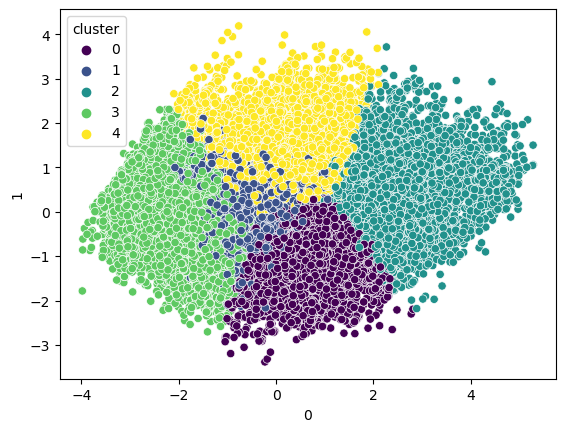

In [110]:
sns.scatterplot(data=df_pca,x=df_pca.iloc[:,0],y=df_pca.iloc[:,1],hue='cluster',palette='viridis')

In [ ]:
# graph = components[:, 0:2]


# loadings = graph

# fig = px.scatter(graph, x=0, y=1, color=df_pca['cluster'])

# for i, feature in enumerate(new_columns):
#     fig.add_annotation(
#         ax=0, ay=0,
#         axref="x", ayref="y",
#         x=loadings[i, 0],
#         y=loadings[i, 1],
#         showarrow=True,
#         arrowsize=2,
#         arrowhead=2,
#         xanchor="right",
#         yanchor="top"
#     )
#     fig.add_annotation(
#         x=loadings[i, 0],
#         y=loadings[i, 1],
#         ax=0, ay=0,
#         xanchor="center",
#         yanchor="bottom",
#         text=feature,
#         yshift=5,
#     )
# fig.show()


## Analyse

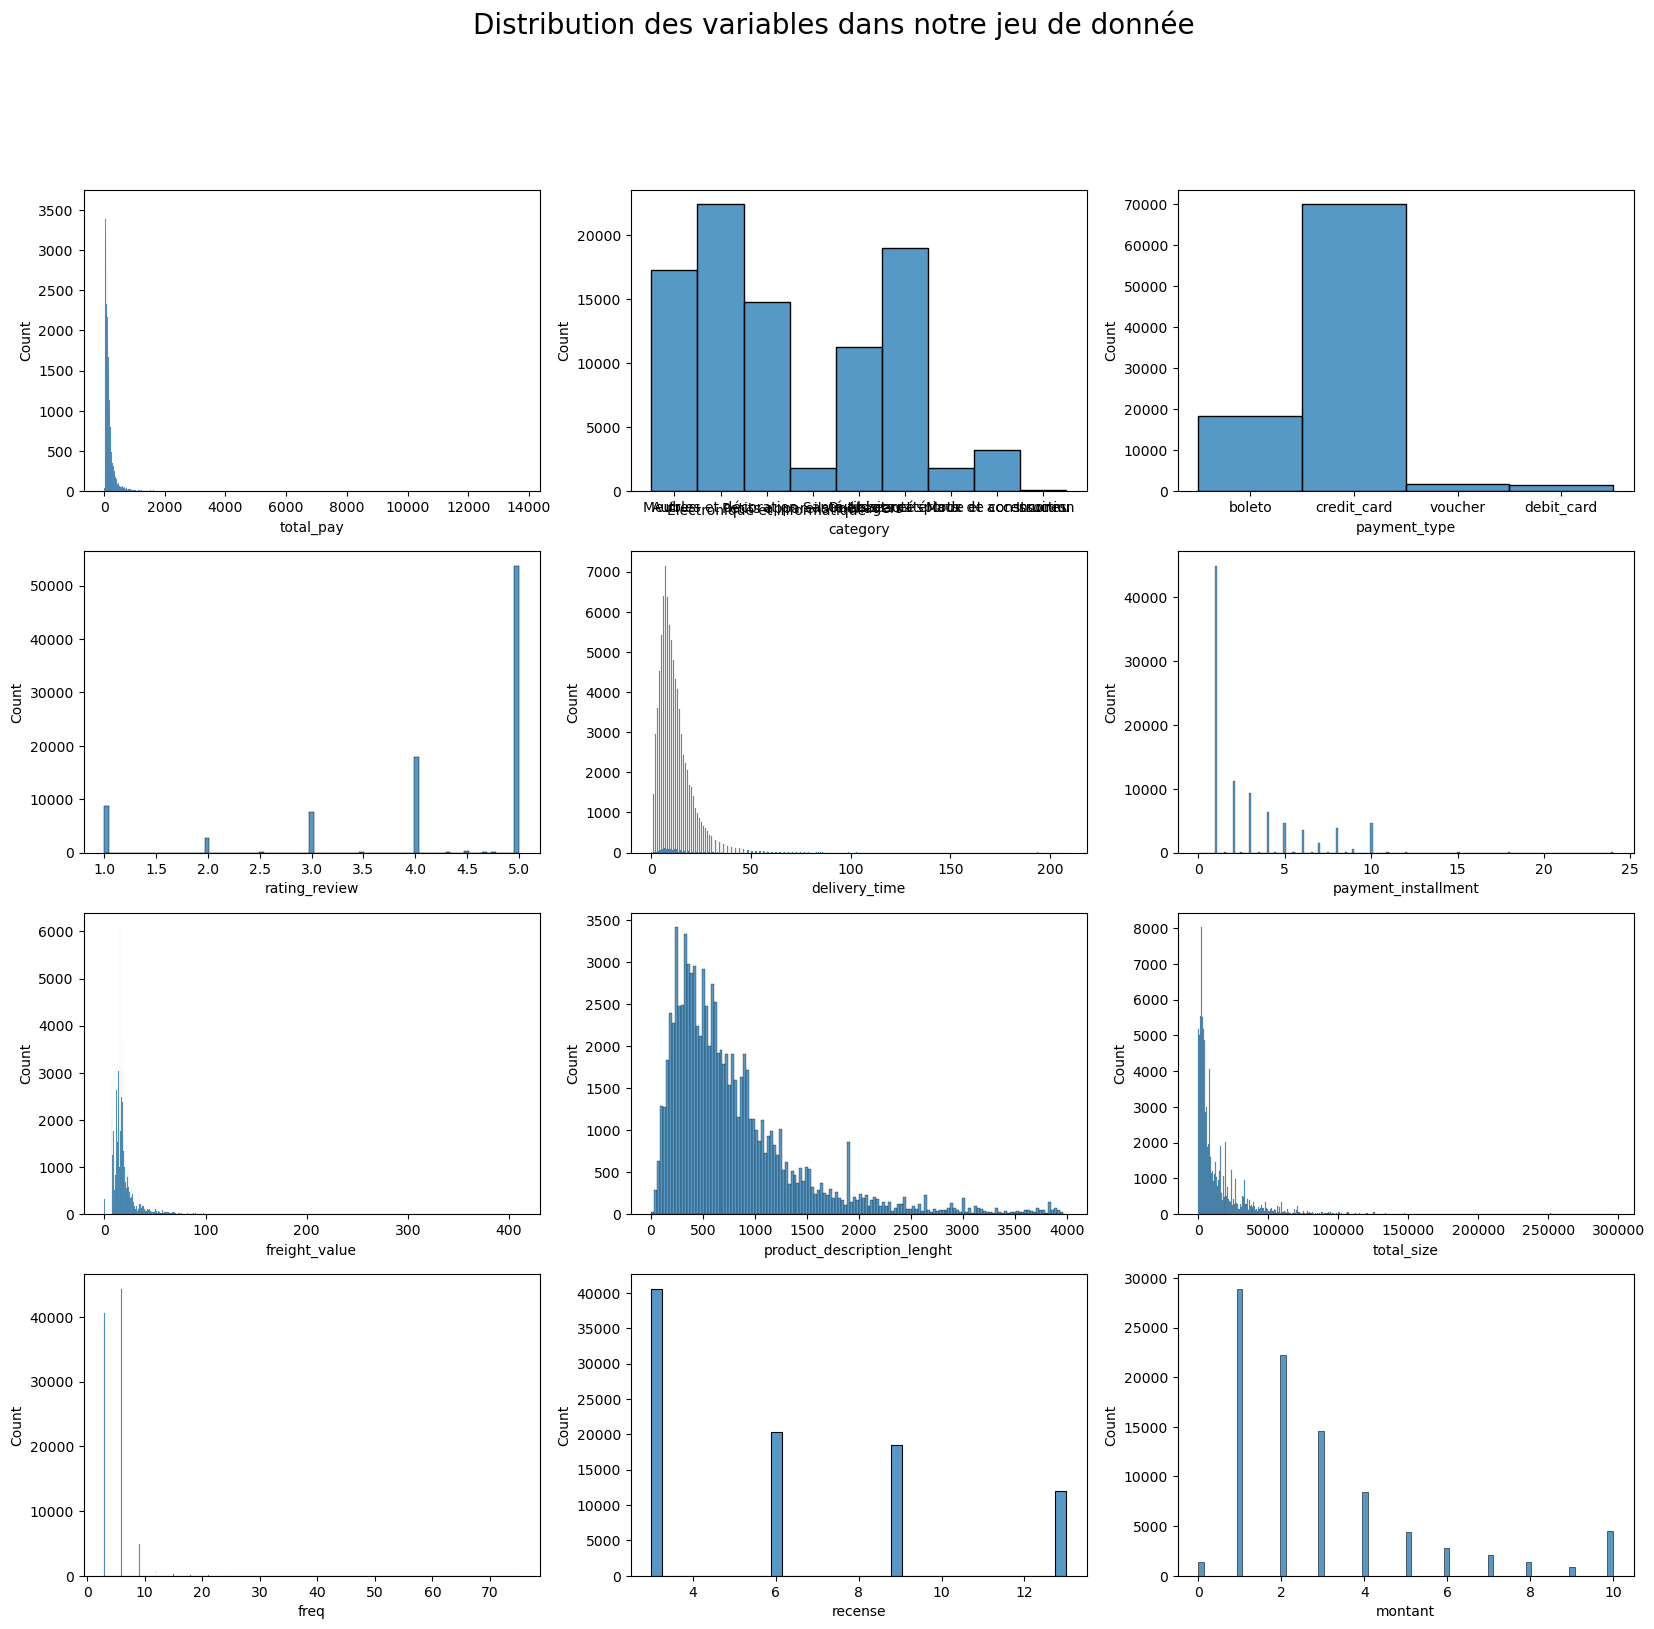

In [111]:
fig, ax =plt.subplots(4,3,figsize=(20,18))
plt.suptitle("Distribution des variables dans notre jeu de donnée",fontsize =20)
n=0
p=0
for name in df_full.columns.tolist():
    sns.histplot(ax=ax[n,p],x=name,data=df)
    if p ==0 or p%2!=0:
        p+=1
    elif p == 2 :
        p=0
        n+=1

In [112]:
mms = MinMaxScaler(feature_range =(1,5))

In [123]:
clusters_means = df_full.select_dtypes(np.number)
cmn= clusters_means.columns.tolist()

In [124]:
df_clusters = pd.DataFrame(mms.fit_transform(clusters_means),columns =cmn)
df_clusters['clusters']=clusters_list_2018
df_clusters= df_clusters.groupby('clusters').agg('median').reset_index()

In [125]:
df_clusters

,clusters,total_pay,rating_review,delivery_time,payment_installment,freight_value,product_description_lenght,total_size,freq,recense,montant
0,0,1.027607,5.0,1.192308,1.333333,1.164128,1.364092,1.261208,1.000000,1.0,1.8
1,1,1.019870,5.0,1.153846,1.166667,1.147432,1.981946,1.071923,1.166667,2.2,1.8
2,2,1.075843,5.0,1.230769,1.666667,1.293693,1.847543,1.556141,1.166667,2.2,3.0
3,3,1.012333,5.0,1.173077,1.166667,1.140305,1.398195,1.021511,1.166667,2.2,1.4
4,4,1.059263,5.0,1.230769,1.583333,1.177993,1.711133,1.053939,1.166667,2.2,2.6


In [116]:
import plotly.graph_objects as go

In [117]:
# Créer une figure en radar pour chaque cluster
fig = go.Figure()

for cluster, row in df_clusters.iterrows():
    values = row.values.tolist()
    

    

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=cmn,
        fill='toself',
        name=f'Cluster {cluster}'
    ))

# Mettre en forme la figurenum_cols,
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 5]
        ),
    ),
    showlegend=True,
    width=780,
    height=780

)

# Afficher la figure
fig.show()
figsize = (60,60)